# Derive models of spacecraft with star tracker

Do all imports.

In [1]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
import ae353_spacecraft_design as design
from scipy.linalg import solve_continuous_are
import numpy.linalg as la
import ae353_spacecraft_simulate
import matplotlib.pyplot as plt


# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

## Create spacecraft

To start, we will specify the location of four reaction wheels in terms of their right ascension $\alpha$ and declination $\delta$.

In [2]:
wheels = [
    {'alpha': 1 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 3 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 5 * np.pi / 3, 'delta': np.pi / 6},
    {'alpha': 0, 'delta': - np.pi / 2},
]

m, J = design.create_spacecraft(wheels)

# Create the visualizer
vis = design.create_visualizer()
design.show_wheels(vis, wheels)

m, J = design.create_spacecraft(wheels)

# Create the sapce craft model in the URDF format,
display(Markdown(
       r'$$'
    + fr'm = {sym.latex(np.round(m, decimals=2))}'
    +  r' \qquad\qquad '
    + fr'J = {sym.latex(sym.Matrix(J.round(decimals=2)))}'
    +  r'$$'
))

# Show the visualizer
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


$$m = 19.0 \qquad\qquad J = \left[\begin{matrix}23.37 & 0.0 & 0.0\\0.0 & 23.37 & 0.0\\0.0 & 0.0 & 20.08\end{matrix}\right]$$

## Create stars

For this observer we will specify the location of at five stars in terms of their right ascension $\alpha$ and declination $\delta$.

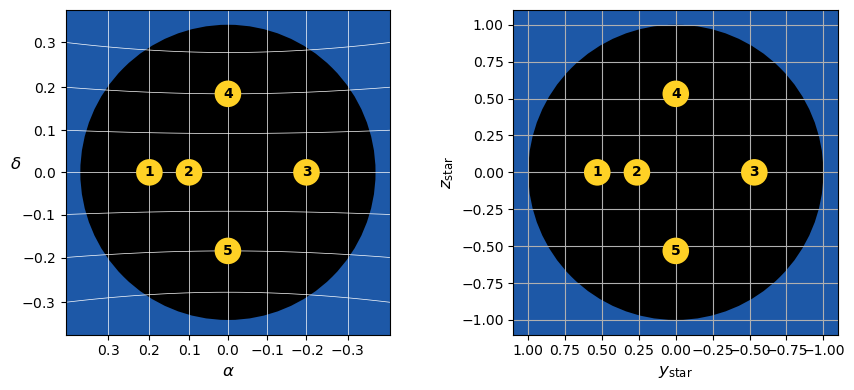

In [3]:
stars = [
    {'alpha':  0.20, 'delta':  0.00},
    {'alpha':  0.10, 'delta':  0.00},
    {'alpha':  -0.20, 'delta':  0.00},
    {'alpha':  0.00, 'delta':  0.20},
    {'alpha':  0.00, 'delta':  -0.20},
]

# Show stars
design.create_stars(stars)
design.show_stars(stars)

## Create dynamic model
Derive the equations of motion. 

In [4]:
# Define yaw, pitch, roll angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
T1 = - tau_1 * sym.Matrix(wheels[0]['xyz']) / np.linalg.norm(wheels[0]['xyz'])
T2 = - tau_2 * sym.Matrix(wheels[1]['xyz']) / np.linalg.norm(wheels[1]['xyz'])
T3 = - tau_3 * sym.Matrix(wheels[2]['xyz']) / np.linalg.norm(wheels[2]['xyz'])
T4 = - tau_4 * sym.Matrix(wheels[3]['xyz']) / np.linalg.norm(wheels[3]['xyz'])
T = sym.nsimplify(T1 + T2 + T3 + T4)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
Jx, Jy, Jz = [sym.nsimplify(j) for j in np.diag(J)]
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                    [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                    [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right).$$

Here is the function $f$:

In [5]:
f

Matrix([
[                                                                                                                                                                             (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                                                                                                          w_y*cos(phi) - w_z*sin(phi)],
[                                                                                                                                                              w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-433012701892219*tau_1/23367395830000000 + 866025403784439*tau_2/23367395830000000 - 433012701892219*tau_3/23367395830000000 - 612323399573677*tau_4/233673958300000000000000000000000 + 329052083*w_y*w_z/2336739583],
[                                                                       -75000000*tau_1/2336739583 - 106057523872491*tau_2/

## Create sensor model

Derive the sensor model for one star.

In [6]:

alpha, delta = sym.symbols('alpha, delta')

# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                              [sym.sin(delta)]])

# Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

# Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

# Position of star in image frame
r = sym.nsimplify(design.scope_radius)
p_star_in_image = (1 / r) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                        [p_star_in_body[2] / p_star_in_body[0]]])

# Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)

The sensor model has the following form:

$$\begin{bmatrix} y_\text{star} \\ z_\text{star} \end{bmatrix} = g(\psi, \theta, \phi, \alpha, \delta).$$

Here is the function $g$:

In [7]:
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

## Derive the controller and observer

The derivation for A and B is done to arrive in standard state-space form.

$$\dot x = Ax + Bu$$

In [8]:
best_params = (0.2682695795279725,0.2682695795279725,0.2682695795279725,0.2682695795279725)

m = (psi, theta, phi, w_x, w_y, w_z)
n = (tau_1, tau_2, tau_3, tau_4)
mn = (psi, theta, phi, w_x, w_y, w_z, tau_1, tau_2, tau_3, tau_4)

xd = f

An = sym.lambdify(mn, xd.jacobian(m))
Bn = sym.lambdify(mn, xd.jacobian(n))

# the satilite must be stationary and not be 
# applying any torque to stop the wheels from going to fast
A = An(0,0,0,0,0,0,0,0,0,0)
B = Bn(0,0,0,0,0,0,0,0,0,0)
print("Matrix A:")
display(sym.Matrix(A))
print("Matrix B:")
display(sym.Matrix(B))

Matrix A:


Matrix([
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

Matrix B:


Matrix([
[                0.0,                   0.0,                 0.0,                   0.0],
[                0.0,                   0.0,                 0.0,                   0.0],
[                0.0,                   0.0,                 0.0,                   0.0],
[-0.0185306358073628,    0.0370612716147257, -0.0185306358073628, -2.62041779934909e-18],
[-0.0320960027149076, -4.53869676553046e-18,  0.0320960027149076,                   0.0],
[-0.0249042741960589,   -0.0249042741960589, -0.0249042741960589,    0.0498085483921178]])

Check the controllability of the system.

In [9]:
W = B
for i in range(B.shape[0] - 1):
    W = np.block([W, la.matrix_power(A, i + 1) @ B])

if W.shape[0] == la.matrix_rank(W):
    print("System is controllable.")
else:
    print("System is not controllable.")

System is controllable.


Now to derive the observer. The observer will be in the form:
$$y=Cx$$

In [10]:
g_all = []
for s in stars:
    gi = g.subs({alpha: s['alpha'], delta: s['delta']})
    g_all.append(gi)
gm = sym.Matrix.vstack(*g_all)  # size 2N x 1

m = sym.Matrix([psi, theta, phi])
Cn = sym.lambdify(m,gm.jacobian(m))

C = Cn(0,0,0) # Use the same equilibirum point
C = np.hstack((C, np.zeros((C.shape[0], 3)))) # 2N x 6
print("Matrix C:")
display(sym.Matrix(C))

Matrix C:


Matrix([
[-2.73286481605181,              0.0,                0.0, 0.0, 0.0, 0.0],
[              0.0,            2.625, -0.532113843210265, 0.0, 0.0, 0.0],
[-2.65142599685905,              0.0,                0.0, 0.0, 0.0, 0.0],
[              0.0,            2.625, -0.263378514224308, 0.0, 0.0, 0.0],
[-2.73286481605181,              0.0,                0.0, 0.0, 0.0, 0.0],
[              0.0,            2.625,  0.532113843210265, 0.0, 0.0, 0.0],
[           -2.625,              0.0,  0.532113843210264, 0.0, 0.0, 0.0],
[              0.0, 2.73286481605181,                0.0, 0.0, 0.0, 0.0],
[           -2.625,              0.0, -0.532113843210264, 0.0, 0.0, 0.0],
[              0.0, 2.73286481605181,                0.0, 0.0, 0.0, 0.0]])

## Find K and L

Let's define functions to handle preforming LQR and finding K and L.

In [11]:
def lqr(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = la.inv(R) @ B.T @ P
    return K

def findKL(A, B, C, Q, R, Qo, Ro):
    K = lqr(A, B, Q, R)
    L = lqr(A.T, C.T, la.inv(Ro), la.inv(Qo)).T
    return K,L

## Setup Simulation

We can setup the controller to operate in the form:

$$\dot{\widehat{x}} = A\widehat{x}+Bu-L(C\widehat{x}-y) \\
\begin{align*}\dot{x}&=Ax+Bu\\ y&=Cx. \end{align*}$$

Configure ```full_test``` to ```True``` to run the intend amount of iterations for the testing, or leave it as is to run fewer.

In [ ]:
full_test = False

In [12]:
class Controller:
    def __init__(self, A, B, C, K, L, stars, dt = 0.04):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.dt = dt
        self.xhat = np.zeros(6)
        self.star_e = stars

        # For logging
        self.t_log = []
        self.xhat_log = []

    
    def reset(self):
        self.xhat = np.zeros(6)
        self.t_log = []
        self.xhat_log = []
    
    def run(self, t, star_measurements):
        u = -self.K @ self.xhat

        y = star_measurements - self.star_e

        self.xhat += self.dt * (
            self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
        )
        
        # Record data
        self.t_log.append(t)
        self.xhat_log.append(self.xhat.copy())

        torque_1, torque_2, torque_3, torque_4 = u
        
        return torque_1, torque_2, torque_3, torque_4
    
    def get_logs(self):
        return np.array(self.t_log), np.array(self.xhat_log)
    
stars_e = [0.5321138432102653, 0.0, 0.2633785142243077, 0.0, -0.5321138432102653, 0.0, 0.0, 0.5321138432102653, 0.0, -0.5321138432102653]




Configure the simulation parameters. We will use a fixed seed for the upcomming testing.

In [13]:
simulator = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=1415,
)

simulator.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    },
    scope_noise=0.1,
    space_debris=False,
    docking_time=20
)

To find the best weight matrices, $Q,R,Q_o,R_o$ we will use an iterative process to test many values. We will socre their preformance using the following function. This function compares the preformance of the observer and controller outputs to a no-noise idealized senario.

In [14]:
def compute_rotation_score(true_rot, est_rot):
    est_rot_reordered = est_rot[:, [2, 1, 0]]
    mse = np.mean((true_rot - est_rot_reordered)**2)
    return mse

Loop over 256 simulations to determine which values for the weight matricies score the best.

In [ ]:
# Starting LQR guesses
Qm, Q0m  = 1,1
Qd = np.diag((50,50,50,1,1,1)).astype(float)
Rd = np.diag((1,1,1,1)).astype(float)
Q0d = np.eye(10).astype(float)
R0d = np.eye(6).astype(float)

Q = Qd*Qm
R = Rd
Q0 = Q0d*Q0m
R0 = R0d

best_params = (Q, R, Q0, R0)

if full_test:
    n = 16
else:
    n = 4
    
values = np.logspace(-8, 8, n)

print("Total sims:", n**2)
best_score = np.inf
iters = 1

for Qm in values:
    for Q0m in values:
        Q = Qd*Qm
        R = Rd
        Q0 = Q0d*Q0m
        R0 = R0d

        K,L = findKL(A,B,C,Q,R,Q0,R0)
        controller = Controller(A,B,C,K,L,stars_e)
        controller.reset()

        simulator.reset(
        initial_conditions={
            'psi': 0.,
            'theta': 0.,
            'phi': 0.,
            'w_x': 0.1, #Test Recovory
            'w_y': 0.,
            'w_z': 0.,
        }, scope_noise=0.1, space_debris=True, docking_time=30)

        data = simulator.run(controller,max_time=30.0,data_filename=None,video_filename=None,print_debug=False)

        true_rot = np.vstack([data['phi'], data['theta'], data['psi']]).T
        t_est, xhat_log = controller.get_logs()
        
        iters += 1
        
        if t_est.size > 0 and t_est[-1] > 19.9:
            est_rot = xhat_log[:, 0:3]
            min_len = min(len(true_rot), len(est_rot))
            score = compute_rotation_score(true_rot[:min_len], est_rot[:min_len])
            print(f"Iteration {iters}, Score: {score}")
            if score < best_score:
                best_score = score
                best_params = (Qm,1,Q0m,1)


Total sims: 256
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW


C:\Users\jelly\AppData\Local\Temp\ipykernel_9032\2165181174.py:28: RuntimeWarning: overflow encountered in matmul
  self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
C:\Users\jelly\AppData\Local\Temp\ipykernel_9032\2165181174.py:28: RuntimeWarning: invalid value encountered in matmul
  self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)
C:\Users\jelly\AppData\Local\Temp\ipykernel_9032\2165181174.py:23: RuntimeWarning: invalid value encountered in matmul
  u = -self.K @ self.xhat


STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 22, Score: 0.120855639394208
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 34, Score: 0.9724066383607071
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 41, Score: 0.18932203841206233
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 43, Score: 0.6100926961196699
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STO

C:\Users\jelly\AppData\Local\Temp\ipykernel_9032\310125687.py:3: RuntimeWarning: overflow encountered in square
  mse = np.mean((true_rot - est_rot_reordered)**2)


STOPED DUE TO STAR OUT OF VIEW
Iteration 99, Score: 0.562557306546298
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 104, Score: 0.0008762983553147305
STOPED DUE TO STAR OUT OF VIEW
Iteration 105, Score: 0.0007713920893172774
Iteration 106, Score: 0.0003771601106058063
STOPED DUE TO STAR OUT OF VIEW
Iteration 107, Score: 0.0012302476827467474
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 116, Score: 0.46751491472581863
Iteration 117, Score: 0.46253333378787775
Iteration 118, Score: 0.05281964254641331
STOPED DUE TO STAR OUT OF VIEW
Iteration 120, Score: 0.00036794701553947165
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 122, Score: 0.00033789686210614284
STOPED DUE 

C:\Users\jelly\AppData\Local\Temp\ipykernel_9032\2165181174.py:23: RuntimeWarning: overflow encountered in matmul
  u = -self.K @ self.xhat


STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 166, Score: 0.06332810546404027
Iteration 167, Score: 0.006143338403263473
Iteration 168, Score: 0.0010303978027560883
Iteration 169, Score: 0.0005856319471136058
Iteration 170, Score: 0.0002751938908750784
Iteration 171, Score: 0.0011841643025625606
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
STOPED DUE TO STAR OUT OF VIEW
Iteration 183, Score: 0.002523028493071547
Iteration 184, Score: 0.0013739017120715216
Iteration 185, Score: 0.0002456929592206331
Iteration 186, Score: 0.0006874878805164134
STOPED DUE TO STAR OUT OF VIEW
Iteration 187, Score: 0.0017838859220

Print out what multipliers for $Q$ and $Q_o$ did the best.

In [16]:
print("Qm:",best_params[0])
print("Rm:",best_params[1])
print("Q0m:",best_params[2])
print("R0m:",best_params[3])

Qm: 39.81071705534969
Rm: 1
Q0m: 0.29286445646252374
R0m: 1


Lets run the simulation again to see how it did.

In [17]:
Q = Qd*best_params[0]
R = Rd*best_params[1]
Q0 = Q0d*best_params[2]
R0 = R0d*best_params[3]

K,L = findKL(A,B,C,Q,R,Q0,R0)

simulator_D = ae353_spacecraft_simulate.Simulator(display=True,seed=1415)

simulator_D.reset(
    initial_conditions={
        'psi': 0.,
        'theta': 0.,
        'phi': 0.,
        'w_x': 0.1, #Test Recovory
        'w_y': 0.,
        'w_z': 0.,
    }, scope_noise=0.1, space_debris=True, docking_time=30)

controller = Controller(A,B,C,K,L,stars_e)
controller.reset()
data = simulator_D.run(controller,max_time=30.0,data_filename=None,video_filename=None,print_debug=False)

has_docked = simulator.has_docked()
if has_docked:
    print('The space-cat docked.')
else:
    print('The space-cat did not dock.')

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
The space-cat did not dock.


We can now plot out the true orientation and angular velocity of the satellite and compare it to the state estimate.

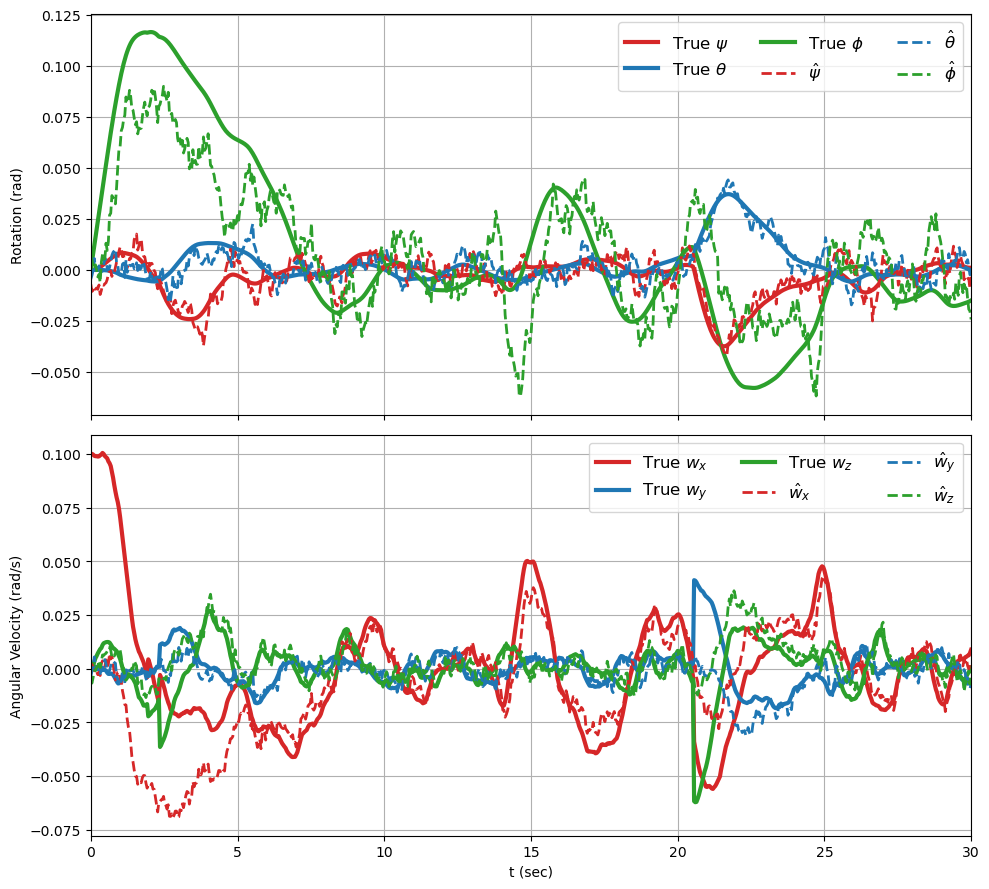

In [18]:
# Get logged estimates from the controller
t_est, xhat_log = controller.get_logs()

# Create figure with three subplots
fig, (ax_ori_est, ax_vel_est) = plt.subplots(2, 1, figsize=(10, 9), sharex=True)

# Choose consistent colors for each component
color_psi = 'tab:red'
color_theta = 'tab:blue'
color_phi = 'tab:green'

color_wx = 'tab:red'
color_wy = 'tab:blue'
color_wz = 'tab:green'

# ---- 1. Plot Rotation Estimates vs True Rotation ----
ax_ori_est.plot(data['t'], data['psi'], label=r'True $\psi$', color=color_psi, linewidth=3)
ax_ori_est.plot(data['t'], data['theta'], label=r'True $\theta$', color=color_theta, linewidth=3)
ax_ori_est.plot(data['t'], data['phi'], label=r'True $\phi$', color=color_phi, linewidth=3)

ax_ori_est.plot(t_est, xhat_log[:, 0], '--', label=r'$\hat{\psi}$', color=color_psi, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 1], '--', label=r'$\hat{\theta}$', color=color_theta, linewidth=2)
ax_ori_est.plot(t_est, xhat_log[:, 2], '--', label=r'$\hat{\phi}$', color=color_phi, linewidth=2)

ax_ori_est.set_xlim(0, 30)
ax_ori_est.set_ylabel("Rotation (rad)")
ax_ori_est.legend(fontsize=12, ncol=3)
ax_ori_est.grid()

# ---- 2. Plot Angular Velocity Estimates vs True Angular Velocity ----
ax_vel_est.plot(data['t'], data['w_x'], label=r'True $w_x$', color=color_wx, linewidth=3)
ax_vel_est.plot(data['t'], data['w_y'], label=r'True $w_y$', color=color_wy, linewidth=3)
ax_vel_est.plot(data['t'], data['w_z'], label=r'True $w_z$', color=color_wz, linewidth=3)

ax_vel_est.plot(t_est, xhat_log[:, 3], '--', label=r'$\hat{w}_x$', color=color_wx, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 4], '--', label=r'$\hat{w}_y$', color=color_wy, linewidth=2)
ax_vel_est.plot(t_est, xhat_log[:, 5], '--', label=r'$\hat{w}_z$', color=color_wz, linewidth=2)

ax_vel_est.set_xlim(0, 30)
ax_vel_est.set_ylabel("Angular Velocity (rad/s)")
ax_vel_est.set_xlabel("t (sec)")
ax_vel_est.legend(fontsize=12, ncol=3)
ax_vel_est.grid()

fig.tight_layout()
plt.show()

We can also visuialize what the reaction wheels are doing.

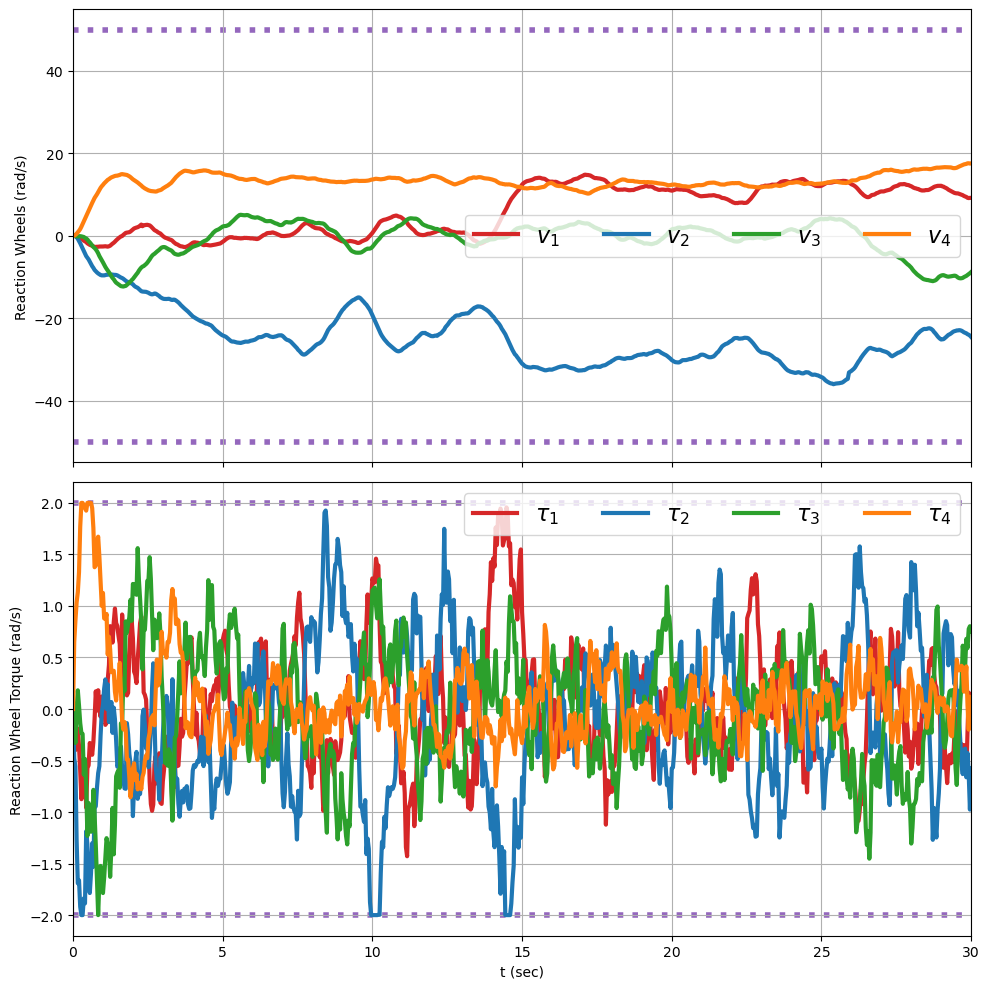

In [26]:
# Create figure with three subplots
fig, (ax_rwvel, ax_rwtau) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Choose consistent colors for each component
color_t1 = 'tab:red'
color_t2 = 'tab:blue'
color_t3 = 'tab:green'
color_t4 = 'tab:orange'

# ---- 1. Plot Rotation Estimates vs True Rotation ----
ax_rwvel.plot(data['t'], data['wheel_1_velocity'], label=r'$v_1$', color=color_t1, linewidth=3)
ax_rwvel.plot(data['t'], data['wheel_2_velocity'], label=r'$v_2$', color=color_t2, linewidth=3)
ax_rwvel.plot(data['t'], data['wheel_3_velocity'], label=r'$v_3$', color=color_t3, linewidth=3)
ax_rwvel.plot(data['t'], data['wheel_4_velocity'], label=r'$v_4$', color=color_t4, linewidth=3)

ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)

ax_rwvel.set_xlim(0, 30)
ax_rwvel.set_ylabel("Reaction Wheels (rad/s)")
ax_rwvel.legend(fontsize=16, ncol=4)
ax_rwvel.grid()

# ---- 2. Plot Angular Velocity Estimates vs True Angular Velocity ----
ax_rwtau.plot(data['t'], data['torque_1'], label=r'$\tau_1$', color=color_t1, linewidth=3)
ax_rwtau.plot(data['t'], data['torque_2'], label=r'$\tau_2$', color=color_t2, linewidth=3)
ax_rwtau.plot(data['t'], data['torque_3'], label=r'$\tau_3$', color=color_t3, linewidth=3)
ax_rwtau.plot(data['t'], data['torque_4'], label=r'$\tau_4$', color=color_t4, linewidth=3)

ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)

ax_rwtau.set_xlim(0, 30)
ax_rwtau.set_ylabel("Reaction Wheel Torque (rad/s)")
ax_rwtau.set_xlabel("t (sec)")
ax_rwtau.legend(fontsize=16, ncol=4)
ax_rwtau.grid()

fig.tight_layout()
plt.show()

Round the K and L matrices to 5 significant figures and print them out:

In [32]:
def round_trunc(mat, sigfigs=5, threshold=1e-10):
    def process(x):
        x_eval = sym.N(x, sigfigs)
        return 0 if abs(x_eval) < threshold else x_eval
    return mat.applyfunc(process)

print("Matrix K:")
display(round_trunc(sym.Matrix(K)))
print("Matrix L:")
display(round_trunc(sym.Matrix(L)))
print(K.tolist())
print(L.tolist())

Matrix K:


Matrix([
[-16.863, -31.548, -18.214, -18.283, -31.667, -14.112],
[-16.863,       0,  36.428,  36.566,       0, -14.112],
[-16.863,  31.548, -18.214, -18.283,  31.667, -14.112],
[ 33.726,       0,       0,       0,       0,  28.224]])

Matrix L:


Matrix([
[-0.31465,        0, -0.30527,        0, -0.31465,       0,  -0.30223,        0,   -0.30223,        0],
[       0,  0.29396,        0,  0.29895,        0, 0.31373, 0.0098819,  0.31633, -0.0098819,  0.31633],
[       0, -0.50463,        0, -0.22516,        0, 0.60213,   0.55338, 0.050752,   -0.55338, 0.050752],
[       0, -0.24272,        0, -0.10933,        0, 0.28549,    0.2641, 0.022267,    -0.2641, 0.022267],
[       0,  0.23411,        0,   0.2363,        0, 0.24278, 0.0043356,  0.24824, -0.0043356,  0.24824],
[-0.24736,        0, -0.23999,        0, -0.24736,       0,  -0.23759,        0,   -0.23759,        0]])

[[-16.863044347954183, -31.547867224009707, -18.214169634140518, -18.283210512033175, -31.667449532318944, -14.111999205482041], [-16.863044347954187, -2.44924166995886e-15, 36.42833926828098, 36.56642102406631, 3.19388408325931e-14, -14.111999205482029], [-16.86304434795418, 31.547867224009686, -18.21416963414044, -18.283210512033104, 31.667449532318894, -14.111999205482032], [33.726088695908366, 1.1698948878930566e-14, 1.0723793771458358e-14, 5.469433752388786e-15, 6.579367178216192e-15, 28.223998410964068]]
[[-0.31464991670355824, 1.2267175983694324e-17, -0.30527341277810677, 1.1191527921881571e-17, -0.31464991670355824, 8.007466430264044e-18, -0.3022308408727313, 1.0553877506883532e-17, -0.3022308408727313, 1.0553877506883532e-17], [-1.0553877506883532e-17, 0.29396198761815295, -1.0239374090169586e-17, 0.2989526920910023, -1.0553877506883532e-17, 0.3137258418712964, 0.009881927126571665, 0.3163292739723061, -0.009881927126571686, 0.3163292739723061], [1.0938646413460564e-17, -0.504

We can now run 100 fully random tests to see how the satellite fairs.

In [ ]:
simulator_f = ae353_spacecraft_simulate.Simulator(
    display=False,
    seed=None,
)

if full_test:
    num_simulations = 100
else:
    num_simulations = 10
successful_landings = 0
failed_landings = 0

# Manually define to ensure it works even if out of order cell execution
best_params = (39.81071705534969, 1, 0.29286445646252374, 1)

Q = Qd*best_params[0]
R = Rd*best_params[1]
Q0 = Q0d*best_params[2]
R0 = R0d*best_params[3]
K,L = findKL(A,B,C,Q,R,Q0,R0)
controller = Controller(A,B,C,K,L,stars_e)

for i in range(num_simulations):
    print("Sim:",i+1, "of", num_simulations)
    simulator_f.reset(
        initial_conditions=None,
        scope_noise=0.1,
        space_debris=True,
        docking_time=30.
    )
    
    controller.reset()  # Reset controller
    
    # Run simulation
    data = simulator_f.run(
    controller,
    max_time=30.0,
    data_filename=None,
    video_filename=None,
    print_debug=False,
    )
    
    # Check if the spacecat has ducked
    if simulator_f.has_docked():
        successful_landings += 1
    else:
        failed_landings += 1

Sim: 1 of 10
Sim: 2 of 10
Sim: 3 of 10
Sim: 4 of 10
STOPED DUE TO WHEEL EXCEDING MAX VELOCITY
Sim: 5 of 10
Sim: 6 of 10
Sim: 7 of 10
Sim: 8 of 10
Sim: 9 of 10
Sim: 10 of 10


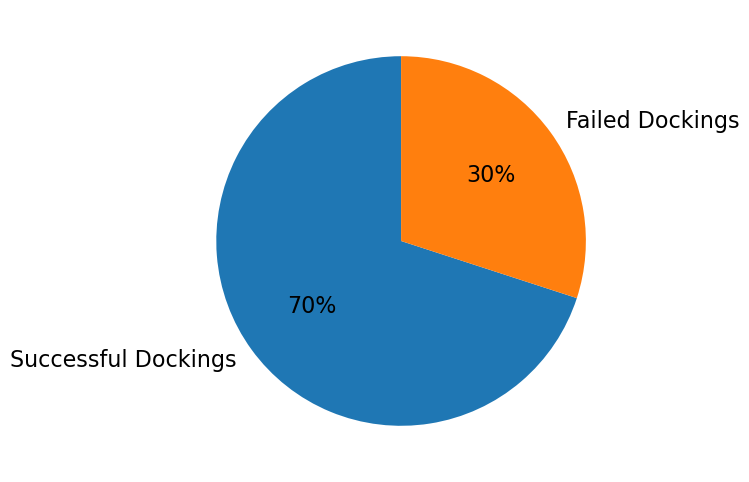

In [23]:
labels = ['Successful Dockings', 'Failed Dockings']
sizes = [successful_landings, failed_landings]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90,textprops={'fontsize': 16})
plt.show()